# Packages Loading

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel

import matplotlib.pyplot as plt

# Wandb login & Config & Loading data

In [2]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_key")

wandb.login(key = secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
class config:
    seed = 42
    
    ## train parameters
    BATCH_SIZE = 64
    EPOCHES = 800
    num_warmup_rate=0.05
    
    model_name = 'BERT-MLP'

In [4]:
# df = pd.read_csv('/kaggle/input/mintres/train.tsv', sep='\t')
df = pd.read_csv('/kaggle/input/mintres2-0/train.tsv', sep='\t')
df_te = pd.read_csv('/kaggle/input/mintres2-0/test.tsv', sep='\t')

In [5]:
df_te.head()

,Dialogue_id,Utterance_id,Text,Label,Start_timestamp,End_timestamp,Source,speaker_name
0,9,1,not everyone can pull off a vest.,Flaunt,"00:08:16,496","00:08:17,764",superstore,superstore person3
1,9,3,"uh, my break's almost over.",Inform,"00:08:22,835","00:08:24,604",superstore,superstore person3
2,9,4,"hey, actually, to use the employee bathroom?",Confirm,"00:08:24,637","00:08:30,210",superstore,superstore person3
3,9,5,"i mean, we have porta-potties, but, uh, you kn...",Explain,"00:08:30,243","00:08:33,513",superstore,superstore person3
4,9,6,"uh, yeah, yeah.",Agree,"00:08:33,546","00:08:35,548",superstore,Nico


In [6]:
# ## 查看文本最大token 粗略
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# text = df[df['Text'].apply(lambda x: len(x))==236]['Text'][2952]
# embed = tokenizer(text, return_tensors='pt', add_special_tokens=True)
# embed['input_ids'].size()

# te_max_len = df_te['Text'].apply(lambda x: len(x)).max()
# text = df_te[df_te['Text'].apply(lambda x: len(x))==te_max_len]['Text'].iloc[1]
# embed = tokenizer(text, return_tensors='pt', add_special_tokens=True)
# embed['input_ids'].size()

# class mapping dict

In [7]:
num_classes = df['Label'].nunique()

In [8]:
label_mapping = {v:i for i,v in enumerate(df['Label'].unique())}
df['label_num'] = df['Label'].map(label_mapping)
df_te['label_num'] = df_te['Label'].map(label_mapping)

# Dataset

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CustomDataset(Dataset):
    def __init__(self, dataframe, num_classes=20):
        self.data = dataframe
        self.num_classes = num_classes
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = self.data.loc[index, 'Text']
        encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True, max_length=76, padding='max_length')
        label = self.data.loc[index, 'label_num']
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=self.num_classes)
        inputs_ids = encoded_input['input_ids'].squeeze(0)
        attention_mask = encoded_input['attention_mask'].squeeze(0)
        return inputs_ids, attention_mask, one_hot_label

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
dataset = CustomDataset(df, num_classes)
val_dataset = CustomDataset(df_te, num_classes)

In [11]:
batch_size = config.BATCH_SIZE  # 批量大小
shuffle = True  # 打乱数据
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2)

# Build Model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
class BERTMLPClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTMLPClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = outputs.last_hidden_states
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        hidden = self.relu(self.fc1(pooled_output))
        logits = self.softmax(self.fc2(hidden))
        return logits

model = BERTMLPClassifier(num_classes=num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
# ## Frozen Bert parameters
# for name, param in model.named_parameters():
#     if 'bert' in name:
#         param.requires_grad = False

In [15]:
each_epoch_steps = len(dataloader)
epoches = config.EPOCHES

In [16]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-6)

# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=each_epoch_steps*epoches, eta_min=1e-7)

In [17]:
from transformers import get_cosine_schedule_with_warmup
# from torch.utils.checkpoint import checkpoint ## gradient_checkpointing_enable() 需要

num_train_steps = config.EPOCHES*each_epoch_steps
num_warmup_steps = int(num_train_steps*config.num_warmup_rate)
## scheduler
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps, num_cycles=0.5)

# wandb.init()

In [18]:
def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

wandb.init(project='NLP-intent-BERT', 
    name=config.model_name,
    config=class2dict(config),
    group=config.model_name,
    job_type="train",
    anonymous="must")

wandb: Currently logged in as: mengvision (numberist). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240511_030950-v3qiqlji
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run BERT-MLP
wandb: ⭐️ View project at https://wandb.ai/numberist/NLP-intent-BERT
wandb: 🚀 View run at https://wandb.ai/numberist/NLP-intent-BERT/runs/v3qiqlji


# Train

In [19]:
import time
lr_list = []
loss_list = []
t_loss_list = []
acc_list = []
best_loss = 1_000
for epoch in range(epoches):
    losses = []
    ## train
    model.train()
    st = time.time()
    for input_ids, attention_mask, labels in dataloader:
        input_ids, attention_mask, labels = input_ids.to(device, dtype=torch.long), attention_mask.to(device, dtype=torch.long), labels.to(device, dtype=torch.float)

        logits = model(input_ids, attention_mask)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()        
        losses.append(loss.item())
        scheduler.step()
        # 更新学习率
    
    v_losses = []
    v_accs = []
    ## validation
    model.eval()
    for input_ids, attention_mask, labels in val_dataloader:
        input_ids, attention_mask, labels = input_ids.to(device, dtype=torch.long), attention_mask.to(device, dtype=torch.long), labels.to(device, dtype=torch.float)
        with torch.no_grad():
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            v_losses.append(loss.item())
            pr = [p.argmax().cpu().numpy() for p in logits]
            gt = [l.argmax().cpu().numpy() for l in labels]
            acc_tmp = [p==g for p,g in zip(pr,gt)]
            v_accs.append(sum(acc_tmp)/len(acc_tmp))
    ed = time.time()
    lr_cur = optimizer.param_groups[0]['lr']
    print(f'[Epoch {epoch+1}/{epoches}] Train Loss: {np.mean(losses):.2f}, Test Loss: {np.mean(v_losses):.2f}, Test acc: {np.mean(v_accs):.2f}, lr: {lr_cur}, time: {ed-st:.0f}s')
    # wandb
    wandb.log({
        f"Epoch": epoch+1,
        f"avg_train_loss": np.mean(losses),
        f"avg_test_loss": np.mean(v_losses),
        f"avg_test_acc": np.mean(v_accs),
        f"lr": lr_cur
    })
    if best_loss > np.mean(losses):
        best_loss = np.mean(losses)
        model_path = 'model_best_tr.pth'
        torch.save(model.state_dict(), model_path)
    
    loss_list.append(np.mean(losses))
    t_loss_list.append(np.mean(v_losses))
    acc_list.append(np.mean(v_accs))
    lr_list.append(lr_cur)

[Epoch 1/800] Train Loss: 3.40, Test Loss: 3.40, Test acc: 0.03, lr: 5.000000000000001e-07, time: 53s
[Epoch 2/800] Train Loss: 3.40, Test Loss: 3.40, Test acc: 0.05, lr: 1.0000000000000002e-06, time: 53s
[Epoch 3/800] Train Loss: 3.40, Test Loss: 3.40, Test acc: 0.16, lr: 1.5e-06, time: 53s
[Epoch 4/800] Train Loss: 3.39, Test Loss: 3.39, Test acc: 0.21, lr: 2.0000000000000003e-06, time: 53s
[Epoch 5/800] Train Loss: 3.39, Test Loss: 3.38, Test acc: 0.19, lr: 2.5e-06, time: 53s
[Epoch 6/800] Train Loss: 3.37, Test Loss: 3.35, Test acc: 0.19, lr: 3e-06, time: 53s
[Epoch 7/800] Train Loss: 3.33, Test Loss: 3.31, Test acc: 0.22, lr: 3.5e-06, time: 53s
[Epoch 8/800] Train Loss: 3.29, Test Loss: 3.27, Test acc: 0.24, lr: 4.000000000000001e-06, time: 53s
[Epoch 9/800] Train Loss: 3.25, Test Loss: 3.24, Test acc: 0.25, lr: 4.5e-06, time: 53s
[Epoch 10/800] Train Loss: 3.22, Test Loss: 3.21, Test acc: 0.26, lr: 5e-06, time: 53s
[Epoch 11/800] Train Loss: 3.19, Test Loss: 3.19, Test acc: 0.31,

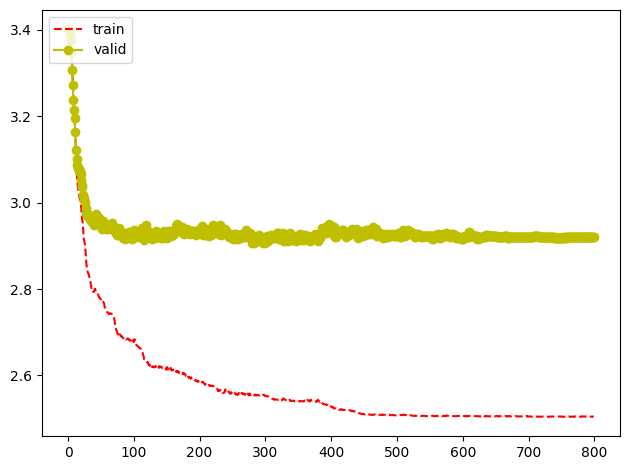

In [20]:
t = np.array(loss_list)
v = np.array(t_loss_list)
e1 = np.arange(len(t))
plt.plot(e1,t, "r--")
plt.plot(e1,v,"oy-")
plt.legend(['train', 'valid'], loc='upper left')
plt.tight_layout()
plt.savefig('loss_fig.png', format="png")
plt.show()

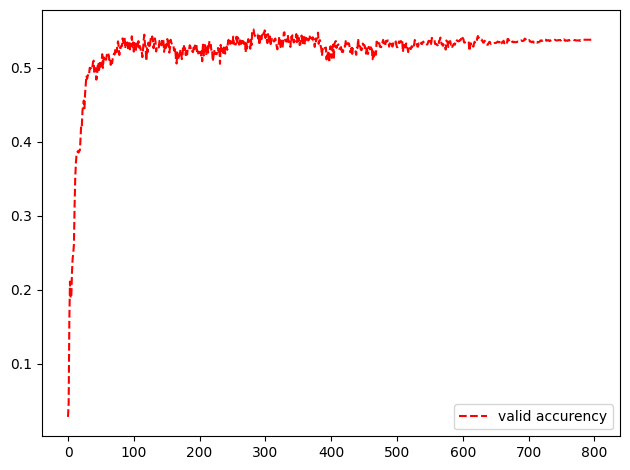

In [21]:
plt.plot(acc_list, "r--", label='valid accurency')
plt.legend()
plt.tight_layout()
plt.savefig('acc_fig.png', format="png")
plt.show()